In [1]:
import os
import sys
import random
from pathlib import Path
import osgeo  #Needed for use on Windows only
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
import geopandas as gpd
from datetime import datetime
import sqlalchemy as sa
%matplotlib inline

In [2]:
sys.path.append(r"../src/collectcube")
from samplegen import *
from db import *

In [5]:
## aoi_in = shapefile or geopkg with polygon objet(s) sample form
aoi_in = Path("../data/smSamp/smSampDistricts.shp")
out_dir = '../data/smSamp'
local_db_path = os.path.join(out_dir, 'landcover.db')
## reference .tif with target crs and resolution
ref_ras = Path("../data/samp_ras.tif")

res = 10

In [10]:
samp_polys = gpd.read_file(aoi_in)
samp_dists = samp_polys['UNQ'].values.tolist()
print(samp_dists)

['D0102_Concepcion_B', 'D0103_Concepcion_H', 'D0217_SanPedro_C', 'D0301_Cordillera_C', 'D0502_Caaguazu_C', 'D0518_Caaguazu_3F', 'D0603_Caazapa_B', 'D0607_Caazapa_SJN', 'D0806_Misiones_SM', 'D1106_Central_I', 'D1119_Central_JAS']


## Get random sample within polygon

In [11]:
def get_multi_poly_sample(aoi_in,sampsize, ref_ras, out_dir):
    local_db_path = os.path.join(out_dir, 'landcover.db')
    pt_file_out = os.path.join(out_dir,'samp_pts.shp')
    box_file_out = os.path.join(out_dir,'samp_boxes.shp')
    
    samp_polys = gpd.read_file(aoi_in)
    samp_dists = samp_polys['UNQ'].values.tolist()
    for i,subply in enumerate(samp_dists):
        if subply == None:
            print('oops -- No UNQ')
        else:
            print(subply)
            gs = get_sample_in_poly(aoi_in, sampsize, seed=992, subpoly=subply)
            gs_shift = move_points_to_pixel_centroids(gs, ref_ras, write_pts=False)
            maxpid = get_max_id_in_db(local_db_path)
            print(f'maxid={maxpid}')
            if i==0:
                pts = get_full_point_file(gs_shift, pt_file_out, res, lastpt=maxpid, write_pts=False)
                ptsdf = make_pixel_table(pts,subply)
            else:
                pts_sub = get_full_point_file(gs_shift, pt_file_out, res, lastpt=maxpid, write_pts=False)
                ptsdf = make_pixel_table(pts_sub,subply)
                pts = pd.concat([pts,pts_sub], axis=0)
    
            #print(ptsdf.tail())
            make_pixel_table_in_db(ptsdf, local_db_path, 'append')
            
    centpts = pts[pts['Center']==1]
    centpts.to_file(pt_file_out, driver='ESRI Shapefile')
    boxes = make_pixel_boxes_from_pts(pts, box_file_out, res, write_boxes=True)
    
    return pts

In [12]:
samp = get_multi_poly_sample(aoi_in,500, ref_ras, out_dir)

D0102_Concepcion_B
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=-1
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D0103_Concepcion_H
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=499
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D0217_SanPedro_C
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=999
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D0301_Cordillera_C
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=1499
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D0502_Caaguazu_C
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:8858
maxid=1999
<class 'geopandas.geodataframe.GeoDataFrame'>
there are 4000 neighbor pixels
there are 4500 total pixels
D0518_Caaguazu_3F
aoi file has crs:epsg:8858
ref_ras has crs:EPSG:88

In [7]:
table_check = check_table(local_db_path,'pixels')

             PID  Center     cent_X     cent_Y   cent_lat  cent_long  ransamp  \
98995  0010999_4       0  2974500.0 -3213020.0 -25.431507 -57.444894        1   
98996  0010999_5       0  2974520.0 -3213020.0 -25.431507 -57.444675        1   
98997  0010999_6       0  2974500.0 -3213030.0 -25.431589 -57.444883        1   
98998  0010999_7       0  2974510.0 -3213030.0 -25.431589 -57.444774        1   
98999  0010999_8       0  2974520.0 -3213030.0 -25.431589 -57.444665        1   

       checked   PID0  PID1          sampgroup  
98995        0  10999     4  D1119_Central_JAS  
98996        0  10999     5  D1119_Central_JAS  
98997        0  10999     6  D1119_Central_JAS  
98998        0  10999     7  D1119_Central_JAS  
98999        0  10999     8  D1119_Central_JAS  


<Axes: >

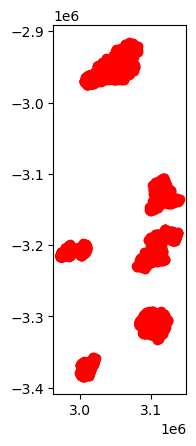

In [4]:
pts = gpd.read_file(os.path.join(out_dir,'samp_pts.shp'))

fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
pts.plot(ax=ax, color='r')

In [4]:
zoom = find_poly_on_image(1, ref_ras, boxes)

## Make other db tables

In [7]:
lc_lut = Path("../data/Class_LUT.csv")
make_LC_table_from_lut(lc_lut, local_db_path, treat_existing='fail')
make_simp_LC_table(lc_lut, local_db_path, [0,30,35,40,80,98], treat_existing='fail')
make_db(local_db_path)

## checks:

In [6]:
engine = create_engine('sqlite:///'+ local_db_path)
with engine.connect() as conn:
    lc5_table = Table('LC5', MetaData(), autoload_with=engine)
    rp = conn.execute(lc5_table.select())
results = rp.fetchall() 
print(results)

[(0, ' ------'), (10, 'NoVeg'), (20, 'LowVeg'), (40, 'MedVeg'), (50, 'HighVeg'), (70, 'Trees'), (99, 'Unknown')]


## updating db (should not need if starting new db)

In [18]:
#local_db_path = '../data/example/landcover.db'
#con = sqlite3.connect(local_db_path)
#c = con.cursor()
## adding a new column to existing table
#c.execute("ALTER TABLE PixelVerification ADD COLUMN entry_lev INTEGER")
## filling column in existing table
#c.execute("UPDATE PixelVerification SET entry_lev = 4 WHERE entry_lev IS NULL")
#con.commit()
#c.close()

In [14]:
engine = create_engine('sqlite:///'+ local_db_path)
with engine.connect() as con:
    df = pd.read_sql_table('PixelVerification', con)
df.head()

,recID,PID,PID0,PID1,imgDate,LC5,LC,HOMONBHD9,ForestProx,WaterProx,...,MEDVEG,TREEPLANT0,HIGHVEG,TREEPLANT,FOREST,Age,Stability,State,Notes,entry_lev
0,1,0_0,0,0,2000-01-01,0,0,8,None,None,...,None,None,None,None,None,None,None,None,None,None


## add first record

In [10]:
## first record:
testDate = datetime(2000,1,1)
with engine.connect() as conn:
    pixvar = Table('PixelVerification', MetaData(), autoload_with=engine)
    query = sa.insert(pixvar).values(PID='0_0', PID0=0, PID1=0, imgDate=testDate,LC5=0,LC=0,HOMONBHD9=8) 
    go = conn.execute(query)
    conn.commit()
print(go.inserted_primary_key)

(1,)


## open db form

In [14]:
from qt import *
from entryform_main import *
local_db_path = '../data/example/landcover.db'
open_obs_ui(local_db_path)

ModuleNotFoundError: No module named 'PyQt5'